In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121
import os
import cv2
from numpy import asarray
from PIL import Image
from functools import partial
from keras.applications import imagenet_utils

In [6]:
### Organizing classes into training, validation, and test
print("Organizing datasets")
masked_imgs = os.listdir('datasets/compiled/with_mask')
no_mask_imgs = os.listdir('datasets/compiled/without_mask')

i = 0
for img in masked_imgs:
    if i < int(0.64*len(masked_imgs)):
        os.rename('datasets/compiled/with_mask/' + img, 'datasets/compiled/train/mask/' + img)
        i += 1
    elif i < int(0.80*len(masked_imgs)):
        os.rename('datasets/compiled/with_mask/' + img, 'datasets/compiled/validation/mask/' + img)
        i += 1
    else:
        os.rename('datasets/compiled/with_mask/' + img, 'datasets/compiled/test/mask/' + img)
        i += 1

j = 0
for img in no_mask_imgs:
    if j < int(0.64*len(no_mask_imgs)):
        os.rename('datasets/compiled/without_mask/' + img,'datasets/compiled/train/no-mask/' + img)
        j += 1
    elif j < int(0.80*len(no_mask_imgs)):
        os.rename('datasets/compiled/without_mask/' + img, 'datasets/compiled/validation/no-mask/' + img)
        j += 1
    else:
        os.rename('datasets/compiled/without_mask/' + img, 'datasets/compiled/test/no-mask/' + img)
        j += 1

print("Images reorganized")

Organizing datasets
Images reorganized


In [7]:
epochs = 2
batch_size = 16

In [4]:
# imagenet_mode_preprocessing_function = partial(imagenet_utils.preprocess_input, mode="torch")

In [8]:
train_datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode="nearest",
    horizontal_flip=True,
    rescale=1./255)

validation_datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode="nearest",
    horizontal_flip=True,
    rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_directory(
        batch_size=batch_size,
		directory='datasets/compiled/train/',
        target_size=(224, 224), 
        classes = ['no-mask','mask'],
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        batch_size=batch_size,
        directory='datasets/compiled/validation/',
        target_size=(224, 224), 
        classes = ['no-mask','mask'],
        class_mode='categorical')

Found 2452 images belonging to 2 classes.
Found 614 images belonging to 2 classes.


In [10]:
### Pre-trained Model (DenseNet121 trained on Imagenet)
model = tf.keras.applications.DenseNet121(include_top=False,weights='imagenet',input_shape=(224,224,3),classes=2)

29084464/29084464 [==============================] - 13s 0us/step


In [11]:
# Transfer Learning
for i in model.layers:
  i.trainable = False

In [12]:
global_avg = tf.keras.layers.GlobalAveragePooling2D()(model.output)
flatten = tf.keras.layers.Flatten()(global_avg)
# drop_out = tf.keras.layers.Dropout(0.4)(flatten)
out = tf.keras.layers.Dense(2,activation='softmax')(flatten)
densenet = tf.keras.Model(inputs=[model.input],outputs=[out])

In [13]:
densenet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [14]:
densenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss="binary_crossentropy",metrics=["accuracy"])

In [15]:
history = densenet.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

C:\Users\Gamalya\AppData\Local\Temp\ipykernel_4660\4044968086.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = densenet.fit_generator(


Epoch 1/2
154/154 [==============================] - ETA: 0s - loss: 0.0691 - accuracy: 0.9759

C:\Python\Sturtup_Academy\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


154/154 [==============================] - 270s 2s/step - loss: 0.0691 - accuracy: 0.9759 - val_loss: 0.1017 - val_accuracy: 0.9674
Epoch 2/2
154/154 [==============================] - 263s 2s/step - loss: 0.0280 - accuracy: 0.9918 - val_loss: 0.0612 - val_accuracy: 0.9805


In [16]:
densenet.save('densenet121_detection_model.h5')

In [17]:
### Metrics
# Testing directories
test_mask_imgs = os.listdir('datasets/compiled/test/mask')
test_no_mask_imgs = os.listdir('datasets/compiled/test/no-mask')

# Numbers of images
total_mask = len(test_mask_imgs)
total_no_mask = len(test_no_mask_imgs)
total = total_mask + total_no_mask

# Confusion Matrix variables
mask_correct = 0
mask_incorrect = 0
no_mask_correct = 0
no_mask_incorrect = 0

# Mask class
for img in test_mask_imgs:
    
    tmp = Image.open('datasets/compiled/test/mask/'+ img)
    test_img = np.asarray(tmp)
    test = test_img.copy()
    test.resize(1,224,224,3)
    ans = densenet.predict(test)
    print(ans)
    if ans[0][1] > ans[0][0]:
        mask_correct += 1
        print("mask")
    elif ans[0][1] < ans[0][0]:
        mask_incorrect += 1
        print("no-mask")
        
    # Mask recall
    mask_recall = mask_correct/total_mask

# No-mask class
for img in test_no_mask_imgs:
    
    tmp = Image.open('datasets/compiled/test/no-mask/' + img)
    test_img = np.asarray(tmp)
    test = test_img.copy()
    test.resize(1,224,224,3)
    ans = densenet.predict(test)
    print(ans)
    
    if ans[0][0] > ans[0][1]:
        no_mask_correct += 1
        print("no-mask")
    elif ans[0][0] < ans[0][1]:
        no_mask_incorrect += 1
        print("mask")
        
    # No-mask recall
    no_mask_recall = no_mask_correct/total_no_mask

# Mask precision
mask_precision = (mask_correct)/(mask_correct + mask_incorrect)

# No-mask precision
no_mask_precision = (no_mask_correct)/(no_mask_correct + no_mask_incorrect)

# Mask F1 score
mask_f1 = 2 * ((mask_recall * mask_precision)/(mask_recall + mask_precision))

# No-mask F1 score
no_mask_f1 = 2 * ((no_mask_recall * no_mask_precision)/(no_mask_recall + no_mask_precision))

# Classification accuracy
accuracy = (mask_correct + no_mask_correct)/total

# Weighted recall
recall = ((mask_recall*total_mask)+(no_mask_recall*total_no_mask))/(total_mask+total_no_mask)

# Weight precision
precision = ((mask_precision*total_mask)+(no_mask_precision*total_no_mask))/(total_mask+total_no_mask)

# Weighted F1 score
f1 = 2 * ((recall * precision)/(recall + precision))

1/1 [==============================] - 2s 2s/step
[[0.9645233  0.03547669]]
no-mask
1/1 [==============================] - 0s 135ms/step
[[1.9176342e-08 1.0000000e+00]]
mask
1/1 [==============================] - 0s 133ms/step
[[9.9982625e-01 1.7382635e-04]]
no-mask
1/1 [==============================] - 0s 119ms/step
[[1.0000000e+00 4.2151777e-12]]
no-mask
1/1 [==============================] - 0s 127ms/step
[[0. 1.]]
mask
1/1 [==============================] - 0s 123ms/step
[[5.086827e-10 1.000000e+00]]
mask
1/1 [==============================] - 0s 123ms/step
[[6.2024778e-27 1.0000000e+00]]
mask
1/1 [==============================] - 0s 142ms/step
[[1.0000000e+00 1.8413309e-23]]
no-mask
1/1 [==============================] - 0s 135ms/step
[[0.01856524 0.9814348 ]]
mask
1/1 [==============================] - 0s 129ms/step
[[0.0013133  0.99868673]]
mask
1/1 [==============================] - 0s 137ms/step
[[9.991672e-01 8.328688e-04]]
no-mask
1/1 [==============================] - 0s 

[[1.0000000e+00 1.5122316e-36]]
[[1.0000000e+00 2.2170308e-31]]
[[1.000000e+00 8.218394e-26]]
[[1. 0.]]
[[1.000000e+00 1.165358e-34]]
[[1. 0.]]
[[1.0000000e+00 6.2061134e-15]]
[[1.0000000e+00 1.6479986e-22]]
[[1.0000000e+00 3.8028965e-28]]
[[1.0000000e+00 2.9308366e-28]]
[[0.362074   0.63792604]]
mask
[[1. 0.]]
[[1.000000e+00 7.656701e-27]]
[[1. 0.]]
[[1.00000000e+00 1.15186325e-14]]
[[1.0000000e+00 1.7927569e-13]]
[[1.000000e+00 2.173793e-12]]
[[1.000000e+00 4.121948e-20]]
[[1.000000e+00 6.218925e-18]]
[[1. 0.]]
[[0.5060194 0.4939806]]
[[1.3815038e-13 1.0000000e+00]]
mask
[[1.000000e+00 4.581734e-19]]
[[9.3557476e-04 9.9906439e-01]]
mask
[[1.0000000e+00 1.4173587e-26]]
[[1.0000000e+00 1.0715171e-17]]
[[0.02044684 0.97955316]]
mask
[[9.999994e-01 6.263071e-07]]
[[1. 0.]]
[[1.0000000e+00 1.0285912e-16]]
[[1. 0.]]
[[1. 0.]]
[[1.0000000e+00 1.0720816e-09]]
[[1.0000000e+00 2.5913222e-21]]
[[1. 0.]]
[[1.0000000e+00 3.5806104e-27]]
[[2.1801108e-10 1.0000000e+00]]
mask
[[1.0000000e+00 1.11977

In [18]:
print("Mask correct predictions: {}".format(mask_correct))
print("Mask incorrect predictions: {}".format(mask_incorrect))

print("No-mask correct predictions: {}".format(no_mask_correct))
print("No-mask incorrect predictions: {}".format(no_mask_incorrect))

print("Mask total images: {}".format(total_mask))
print("No-mask total images: {}".format(total_no_mask))

print("Total test images: {}".format(total))

print("Mask recall: {}".format(mask_recall))
print("No-mask recall: {}".format(no_mask_recall))

print("Mask precision: {}".format(mask_precision))
print("No-mask precision: {}".format(no_mask_precision))

print("Mask F1 score: {}".format(mask_f1))
print("No-mask F1 score: {}".format(no_mask_f1))

print("Classification accuracy: {}".format(accuracy))
print("Weighted recall: {}".format(recall))
print("Weighted precision: {}".format(precision))
print("Weighted F1 score: {}".format(f1))

Mask correct predictions: 204
Mask incorrect predictions: 179
No-mask correct predictions: 251
No-mask incorrect predictions: 133
Mask total images: 383
No-mask total images: 384
Total test images: 767
Mask recall: 0.5326370757180157
No-mask recall: 0.6536458333333334
Mask precision: 0.5326370757180157
No-mask precision: 0.6536458333333334
Mask F1 score: 0.5326370757180157
No-mask F1 score: 0.6536458333333334
Classification accuracy: 0.5932203389830508
Weighted recall: 0.5932203389830508
Weighted precision: 0.5932203389830508
Weighted F1 score: 0.5932203389830508


In [19]:
### Metrics
# Testing directories
test_mask_imgs = os.listdir('datasets/compiled/train/mask')
test_no_mask_imgs = os.listdir('datasets/compiled/train/no-mask')

# Numbers of images
total_mask = len(test_mask_imgs)
total_no_mask = len(test_no_mask_imgs)
total = total_mask + total_no_mask

# Confusion Matrix variables
mask_correct = 0
mask_incorrect = 0
no_mask_correct = 0
no_mask_incorrect = 0

# Mask class
for img in test_mask_imgs:
    
    tmp = Image.open('datasets/compiled/train/mask/'+ img)
    test_img = np.asarray(tmp)
    test = test_img.copy()
    test.resize(1,224,224,3)
    ans = densenet.predict(test)
    print(ans)
    if ans[0][1] > ans[0][0]:
        mask_correct += 1
        print("mask")
    elif ans[0][1] < ans[0][0]:
        mask_incorrect += 1
        print("no-mask")
        
    # Mask recall
    mask_recall = mask_correct/total_mask

# No-mask class
for img in test_no_mask_imgs:
    
    tmp = Image.open('datasets/compiled/train/no-mask/' + img)
    test_img = np.asarray(tmp)
    test = test_img.copy()
    test.resize(1,224,224,3)
    ans = densenet.predict(test)
    print(ans)
    
    if ans[0][0] > ans[0][1]:
        no_mask_correct += 1
        print("no-mask")
    elif ans[0][0] < ans[0][1]:
        no_mask_incorrect += 1
        print("mask")
        
    # No-mask recall
    no_mask_recall = no_mask_correct/total_no_mask

# Mask precision
mask_precision = (mask_correct)/(mask_correct + mask_incorrect)

# No-mask precision
no_mask_precision = (no_mask_correct)/(no_mask_correct + no_mask_incorrect)

# Mask F1 score
mask_f1 = 2 * ((mask_recall * mask_precision)/(mask_recall + mask_precision))

# No-mask F1 score
no_mask_f1 = 2 * ((no_mask_recall * no_mask_precision)/(no_mask_recall + no_mask_precision))

# Classification accuracy
accuracy = (mask_correct + no_mask_correct)/total

# Weighted recall
recall = ((mask_recall*total_mask)+(no_mask_recall*total_no_mask))/(total_mask+total_no_mask)

# Weight precision
precision = ((mask_precision*total_mask)+(no_mask_precision*total_no_mask))/(total_mask+total_no_mask)

# Weighted F1 score
f1 = 2 * ((recall * precision)/(recall + precision))

1/1 [==============================] - 0s 139ms/step
[[4.5982306e-04 9.9954021e-01]]
mask
1/1 [==============================] - 0s 127ms/step
[[0.99413055 0.00586948]]
no-mask
1/1 [==============================] - 0s 133ms/step
[[0.607338 0.392662]]
no-mask
1/1 [==============================] - 0s 129ms/step
[[0.03616633 0.9638337 ]]
mask
1/1 [==============================] - 0s 131ms/step
[[1.000000e+00 8.425435e-17]]
no-mask
1/1 [==============================] - 0s 132ms/step
[[9.9981910e-01 1.8097236e-04]]
no-mask
1/1 [==============================] - 0s 131ms/step
[[0.9985404  0.00145964]]
no-mask
1/1 [==============================] - 0s 144ms/step
[[9.9999523e-01 4.7294006e-06]]
no-mask
1/1 [==============================] - 0s 135ms/step
[[9.9999988e-01 1.2445962e-07]]
no-mask
1/1 [==============================] - 0s 127ms/step
[[1.7835947e-33 1.0000000e+00]]
mask
1/1 [==============================] - 0s 138ms/step
[[0.01630224 0.98369783]]
mask
1/1 [====================

In [20]:
print("Mask correct predictions: {}".format(mask_correct))
print("Mask incorrect predictions: {}".format(mask_incorrect))

print("No-mask correct predictions: {}".format(no_mask_correct))
print("No-mask incorrect predictions: {}".format(no_mask_incorrect))

print("Mask total images: {}".format(total_mask))
print("No-mask total images: {}".format(total_no_mask))

print("Total test images: {}".format(total))

print("Mask recall: {}".format(mask_recall))
print("No-mask recall: {}".format(no_mask_recall))

print("Mask precision: {}".format(mask_precision))
print("No-mask precision: {}".format(no_mask_precision))

print("Mask F1 score: {}".format(mask_f1))
print("No-mask F1 score: {}".format(no_mask_f1))

print("Classification accuracy: {}".format(accuracy))
print("Weighted recall: {}".format(recall))
print("Weighted precision: {}".format(precision))
print("Weighted F1 score: {}".format(f1))

Mask correct predictions: 732
Mask incorrect predictions: 493
No-mask correct predictions: 596
No-mask incorrect predictions: 631
Mask total images: 1225
No-mask total images: 1227
Total test images: 2452
Mask recall: 0.5975510204081632
No-mask recall: 0.48573757131214346
Mask precision: 0.5975510204081632
No-mask precision: 0.48573757131214346
Mask F1 score: 0.5975510204081632
No-mask F1 score: 0.48573757131214346
Classification accuracy: 0.5415986949429038
Weighted recall: 0.5415986949429038
Weighted precision: 0.5415986949429038
Weighted F1 score: 0.5415986949429038


In [21]:
load_model = keras.models.load_model('densenet121_detection_model.h5')

In [22]:
face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [24]:
labels_dict={0:'without_mask',1:'with_mask'}
color_dict={0:(0,0,255),1:(0,255,0)}

size = 4
cv2.namedWindow("COVID Mask Detection Video Feed")
webcam = cv2.VideoCapture(0) 

classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

while True:
    rval, im = webcam.read()
    im=cv2.flip(im,1,1)
    
    mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))
 
    faces = classifier.detectMultiScale(mini)

    for f in faces:
        (x, y, w, h) = [v * size for v in f] 
        face_img = im[y:y+h, x:x+w]
        resized=cv2.resize(face_img,(224,224))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,224,224,3))
        reshaped = np.vstack([reshaped])
        result=load_model.predict(reshaped)
        print(result)
        if result[0][0] > result[0][1]:
            percent = round(result[0][0]*100,2)
        else:
            percent = round(result[0][1]*100,2)
        
        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(im,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(im, labels_dict[label] + " " + str(percent) + "%", (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
    if im is not None:   
        cv2.imshow('COVID Mask Detection Video Feed', im)
    key = cv2.waitKey(10)
    
    # Exit
    if key == 27: #The Esc key
        break
        
# Stop video
webcam.release()

# Close all windows
cv2.destroyAllWindows()

1/1 [==============================] - 0s 254ms/step
[[0.9937402  0.00625985]]
1/1 [==============================] - 0s 257ms/step
[[0.96881557 0.0311844 ]]
1/1 [==============================] - 0s 258ms/step
[[0.8787592  0.12124081]]
1/1 [==============================] - 0s 256ms/step
[[0.427641 0.572359]]
1/1 [==============================] - 0s 253ms/step
[[0.79667807 0.20332198]]
1/1 [==============================] - 0s 251ms/step
[[0.9939156  0.00608439]]
1/1 [==============================] - 0s 260ms/step
[[0.98040074 0.01959925]]
1/1 [==============================] - 0s 257ms/step
[[0.99502903 0.004971  ]]
1/1 [==============================] - 0s 253ms/step
[[9.9994540e-01 5.4608226e-05]]
1/1 [==============================] - 0s 260ms/step
[[9.9997675e-01 2.3282180e-05]]
1/1 [==============================] - 0s 261ms/step
[[9.9968159e-01 3.1837632e-04]]
1/1 [==============================] - 0s 264ms/step
[[9.999678e-01 3.216944e-05]]
1/1 [=============================

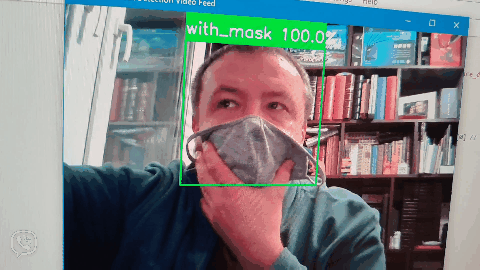

In [26]:
from IPython.display import Image
from IPython.display import display
file_path = 'md.gif'
display(Image(filename=file_path))